In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder 

from tensorflow.keras import utils 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

В качестве исходных данных есть zip файл из нескольких txt файлов, каждый из которого содержит работы того или иного автора (Брэдберри, Стругацкие, Булгаков ...). Извлечем файлы в отдельную директорию:

In [ ]:
!unzip 'drive/My Drive/nn/_4/Тексты писателей-20210525T170220Z-001.zip'

Archive:  drive/My Drive/nn/_4/Тексты писателей-20210525T170220Z-001.zip
  inflating: Тексты писателей/(Клиффорд_Саймак) Тестовая_2 вместе.txt  
  inflating: Тексты писателей/(О. Генри) Тестовая_20 вместе.txt  
  inflating: Тексты писателей/(Стругацкие) Тестовая_2 вместе.txt  
  inflating: Тексты писателей/(О. Генри) Обучающая_50 вместе.txt  
  inflating: Тексты писателей/(Булгаков) Тестовая_2 вместе.txt  
  inflating: Тексты писателей/(Рэй Брэдберри) Обучающая_22 вместе.txt  
  inflating: Тексты писателей/(Рэй Брэдберри) Тестовая_8 вместе.txt  
  inflating: Тексты писателей/(Стругацкие) Обучающая_5 вместе.txt  
  inflating: Тексты писателей/(Макс Фрай) Обучающая_5 вместе.txt  
  inflating: Тексты писателей/(Клиффорд_Саймак) Обучающая_5 вместе.txt  
  inflating: Тексты писателей/(Макс Фрай) Тестовая_2 вместе.txt  
  inflating: Тексты писателей/(Булгаков) Обучающая_5 вместе.txt  


Имя файла содержит указание автора - как для обучающей, так и для валидационной выборки. Через имя файла распределим текста в списки обучающей / выалидационной выборок.

In [ ]:
def readText(fileName): 
    '''
    collect all the texts
    '''
    f = open(fileName, 'r')
    text = f.read()
    text = text.replace('\n', ' ')

    return text

# define the labels
labels = ['О. Генри', 'Стругацкие', 'Булгаков', 'Саймак', 'Фрай', 'Брэдберри']
nLabels = len(labels)

inputFolder = 'Тексты писателей/'

def collectTexts(inputFolder=inputFolder):
    '''
    collect all texts into the train and test smaples
    '''
    trainText, testText = [], []
    for label in labels:
        for fileName in os.listdir(inputFolder):
            if label in fileName:
                if 'Обучающая' in fileName:
                    trainText.append(readText(inputFolder + fileName))
                    print(f'{fileName} added to the train sample')
                if 'Тестовая' in fileName:
                    testText.append(readText(inputFolder+fileName))
                    print(f'{fileName} added to the test sample')

    return trainText, testText

trainText, testText = collectTexts()

(О. Генри) Обучающая_50 вместе.txt added to the train sample
(О. Генри) Тестовая_20 вместе.txt added to the test sample
(Стругацкие) Тестовая_2 вместе.txt added to the test sample
(Стругацкие) Обучающая_5 вместе.txt added to the train sample
(Булгаков) Обучающая_5 вместе.txt added to the train sample
(Булгаков) Тестовая_2 вместе.txt added to the test sample
(Клиффорд_Саймак) Тестовая_2 вместе.txt added to the test sample
(Клиффорд_Саймак) Обучающая_5 вместе.txt added to the train sample
(Макс Фрай) Обучающая_5 вместе.txt added to the train sample
(Макс Фрай) Тестовая_2 вместе.txt added to the test sample
(Рэй Брэдберри) Тестовая_8 вместе.txt added to the test sample
(Рэй Брэдберри) Обучающая_22 вместе.txt added to the train sample


Как результат имеем 2 списка, каждый из которых содержит по списку текста от каждого автора.

In [ ]:
print(f'train: {len(trainText)}, test: {len(testText)}')

train: 6, test: 6


Чтобы ускорить процесс обучения модели и сократить потребление памяти ограничиваем кол-во токенов, которые будут использоваться в словаре:

In [ ]:
maxWordsCount = 20000

Важный шаг для передачи текста в модели это конвертация в численный вид. Это можно сделать в несколько шагов:

**Шаг 1:** Конвертация текста в токены и индексы на базе частотности слова:

In [ ]:
# символы, которые исключаются из текста при передачи в словарь
symbolsToFilter = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff'

# tensorflow.keras.preprocessing.text
tokenizer = Tokenizer(
    num_words = maxWordsCount, # макс кол-во слов в словаре
    filters = symbolsToFilter,
    lower = True, # перевод в нижний регистр
    split = ' ', # текста разбиваются пробелом
    oov_token = 'unknown', # на что заменяются невключенные токены
    char_level = False # если True, каждый символ как токен
)

tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items())

Проверим топ самых часто встречающихся слов:

In [ ]:
print(f'top 10 frequent words:\n{items[-10:]}')
print()
print(f'vocabulary size: {len(items)}')

top 10 frequent words:
[('поджарьте', 133061), ('заполните', 133062), ('мучающие', 133063), ('погремушкой', 133064), ('свистком', 133065), ('потерян', 133066), ('расплывающиеся', 133067), ('миллионе', 133068), ('зияющая', 133069), ('ничтонавстречу', 133070)]

vocabulary size: 133070


Вот функция, чтобы проверить, как индекс у задаваемого слова:

In [ ]:
def checkIndex(word=input()):
    try:
        return f'index is {tokenizer.word_index[word]} out of {len(items)}'
    except KeyError:
        return 'no such word in vocabulary'

checkIndex()

test


'no such word in vocabulary'

**Шаг 2:** конвертация токенов с числовую последовательность

Вызываем метод *fit_on_sequence* для токенайзера:

In [ ]:
trainWordIndices = tokenizer.texts_to_sequences(trainText)
testWordIndices = tokenizer.texts_to_sequences(testText)

Выводим для сравнения исходную и числовую последовательность:

In [ ]:
print(f'original sequence\n{trainText[2][:80]}')
print(f'numeric sequence\n{trainWordIndices[2][:20]}')

original sequence
﻿Белая гвардия   Посвящается[1]  Любови Евгеньевне Белозерской[2]  Пошел мелкий 
numeric sequence
[2939, 5529, 1, 1508, 1, 1, 16735, 1515, 353, 8296, 1267, 2, 121, 15326, 1, 1, 675, 12013, 10580, 17342]


Соберем статистику по собранным массивам:

In [ ]:
myCount = {
    'symbolsInTrain' : 0,
    'wordsInTrain' : 0,
    'symbolsInTest' : 0,
    'wordsInTest' : 0,
}

print('-------------------')
print('TRAIN STATS:')
print('-------------------')
for i in range(nLabels):
    print(
        labels[i], 
        ' ' * (10 - len(labels[i])), 
        len(trainText[i]), 'symbols, ',
        len(trainWordIndices[i]), 'words'
    )
    myCount['symbolsInTrain'] += len(trainText[i])
    myCount['wordsInTrain'] += len(trainWordIndices[i])

print(
    'in total:', 
    ' ' * 1, 
    myCount['symbolsInTrain'], 'symbols, ',
    myCount['wordsInTrain'], 'words'
)
print('-------------------')

print('TEST STATS:')
print('-------------------')
for i in range(nLabels):
    print(
        labels[i], 
        ' ' * (10 - len(labels[i])), 
        len(testText[i]), 'symbols, ',
        len(testWordIndices[i]), 'words'
    )
    myCount['symbolsInTest'] += len(testText[i])
    myCount['wordsInTest'] += len(testWordIndices[i])

print(
    'in total:', 
    ' ' * 1, 
    myCount['symbolsInTest'], 'symbols, ',
    myCount['wordsInTest'], 'words'
)
print('-------------------')

-------------------
TRAIN STATS:
-------------------
О. Генри    1049517 symbols,  160607 words
Стругацкие  2042469 symbols,  313012 words
Булгаков    1765648 symbols,  261465 words
Саймак      1609507 symbols,  251502 words
Фрай        3700010 symbols,  568533 words
Брэдберри   1386454 symbols,  214454 words
in total:   11553605 symbols,  1769573 words
-------------------
TEST STATS:
-------------------
О. Генри    349662 symbols,  53238 words
Стругацкие  704846 symbols,  108621 words
Булгаков    875042 symbols,  132730 words
Саймак      318811 symbols,  50360 words
Фрай        1278191 symbols,  196731 words
Брэдберри   868673 symbols,  132524 words
in total:   4395225 symbols,  674204 words
-------------------


**Шаг 3:** Подготовим обучающую и валидационную массива для подчаи в модель.

Для каждого автора делаем следующие операции:

1. Извлекаем вектора индексов(*wordIndices*)
2. Нарезаем вектор на заданную длину (*xLen*)
3. Сохраняем в переменную
4. Делаем шаг (*step*) и повторяем последовательность

In [ ]:
def getSetFromIndices(wordIndices, xLen, step):
    '''
    нарезает индексы слов на вектора заданной 
    длины (xLen) через заданный шаг
    '''
    xSample = []
    wordsLen = len(wordIndices)
    index = 0

    while (index + xLen <= wordsLen):
        xSample.append(wordIndices[index:index + xLen])
        index += step

    return xSample

def createSetsMultiClasses(wordIndices, xLen, step):
    '''
    подготовка обучающей и валидационной выборки 
    '''
    nLabels = len(wordIndices)
    classesXSamples = [] 
    for wIdx in wordIndices:
        classesXSamples.append(getSetFromIndices(wIdx, xLen, step))
    # размерность classesXSamples:
    # кол-во классов x кол-во шагов x длину шага (xLen)

    xSamples, ySamples = [], []
    for l in range(nLabels):
        xL = classesXSamples[l] 
        for i in range(len(xL)):
            xSamples.append(xL[i])
            # значения класса переводим в бинарную матрицу
            ySamples.append(utils.to_categorical(l, nLabels)) 

    xSamples, ySamples = np.array(xSamples), np.array(ySamples)

    return (xSamples, ySamples)

xLen = 1000
step = 100

xTrain, yTrain = createSetsMultiClasses(trainWordIndices, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndices, xLen, step)
print(
    f'the shapes:\nxTrain: {xTrain.shape}, \nxTest: {xTest.shape}',
    f'\nyTest: {yTrain.shape}, \nyTest: {yTest.shape}'
)

the shapes:
xTrain: (17640, 1000), 
xTest: (6686, 1000) 
yTest: (17640, 6), 
yTest: (6686, 6)


Финальным шагом мы конвертируем полученные вектора в бинарные матрицы (по аналогии с форматом Bag of Words) через метод *sequences_to_matrix*:

In [ ]:
xTrainB = tokenizer.sequences_to_matrix(xTrain.tolist())
xTestB = tokenizer.sequences_to_matrix(xTest.tolist())

Пример того, что получаем на выходе:

In [ ]:
print(f'the shape: {xTrainB.shape}')
print('first 100 elements:')
print(xTrainB[0][:100])

the shape: (17640, 20000)
first 100 elements:
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1.]


После предподготовки данных переходим к написанию структуры самой модели. Архитектура может различаться, для примера возьмем полносвязанные слои с дропаутом и батчнормализацией. 

Дропаут слои случаным образом обнуляются значения некоторых входных нейронов во время процесса обучения, что помогает избегать переобучения.

В качестве функции активации используем *ReLU*, которая преобразует отрицательное входящее значения в ноль, при этом передает далее неотрицательные значения. Формула:

$$ y = max(0, x) $$

В последнем слое используем функцию активации *softmax*, которая при входе размера N применяет экспоненциальную функцию и преобразует в N вероятностей пропорционально экспонентам входящих значений. Формула:

$$ \sigma(z)_i = \frac{e^{z_i}}{\Sigma^K_{j=1} e^{z_i}} $$

В качестве функции ошибки применяется кросс-энтропия (лог функция), стандартный метод оценить эффективность классификационной модели. Функция растет при отклонении предсказанной вероятности от факта. Формула:

$$ CE = - \Sigma^C_i t_i*log(s_i) $$  
где:

$ t_i $ - фактическое значение

$ s_i $ - предсказанное значение

$ i $ - класс

$ C $ - кол-во классов

Epoch 1/20
138/138 [==============================] - 8s 52ms/step - loss: 0.0478 - accuracy: 0.9850 - val_loss: 0.3756 - val_accuracy: 0.8966
Epoch 2/20
138/138 [==============================] - 7s 49ms/step - loss: 4.0744e-04 - accuracy: 1.0000 - val_loss: 0.3152 - val_accuracy: 0.9061
Epoch 3/20
138/138 [==============================] - 7s 48ms/step - loss: 2.2060e-04 - accuracy: 1.0000 - val_loss: 0.2986 - val_accuracy: 0.9107
Epoch 4/20
138/138 [==============================] - 7s 48ms/step - loss: 1.4714e-04 - accuracy: 1.0000 - val_loss: 0.2916 - val_accuracy: 0.9125
Epoch 5/20
138/138 [==============================] - 7s 48ms/step - loss: 1.1253e-04 - accuracy: 1.0000 - val_loss: 0.2924 - val_accuracy: 0.9119
Epoch 6/20
138/138 [==============================] - 7s 48ms/step - loss: 8.3730e-05 - accuracy: 1.0000 - val_loss: 0.2884 - val_accuracy: 0.9133
Epoch 7/20
138/138 [==============================] - 7s 48ms/step - loss: 6.7124e-05 - accuracy: 1.0000 - val_loss: 0.285

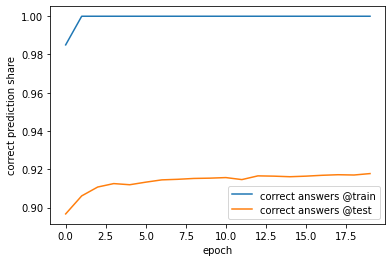

In [ ]:
modelD = Sequential()
modelD.add(Dense(
    200, # кол-во нейронов
    input_dim = maxWordsCount, # входящая размерность
    activation='relu' 
))
modelD.add(Dropout(0.25))
modelD.add(BatchNormalization())
modelD.add(Dense(nLabels, activation='softmax'))

modelD.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = modelD.fit(
    xTrainB,
    yTrain,
    epochs=20,
    batch_size=128,
    validation_data = (xTestB, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

После обучения модели передаем валидационную выборку для оценки ее точности. Для этого:

1. собираем бинарные матрицы для валидационного текста

2. передаем матрицы в модель и проверяем ошибку

In [ ]:
def createTestMultiClasses(wordIndices, xLen, step):
    nLabels = len(wordIndices)
    xTestLabels, xTestLabelsB = [], []
    for wIdx in wordIndices:
        sample = (getSetFromIndices(wIdx, xLen, step))
        xTestLabels.append(sample)
        xTestLabelsB.append(tokenizer.sequences_to_matrix(sample))

    xTestLabels, xTestLabelsB = np.array(xTestLabels, dtype=object), np.array(xTestLabelsB, dtype=object)

    return xTestLabels, xTestLabelsB

def recognizeMultiLabels(model, xTest, modelName):
    print(f'model: {modelName}')

    totalSumRec = 0

    for i in range(nLabels):
        currPred = model.predict(xTest[i]) 
        currOut = np.argmax(currPred, axis=1)

        evVal = []
        for j in range(nLabels):
            evVal.append(len(currOut[currOut==j]) / len(xTest[i]))
        totalSumRec += len(currOut[currOut==i])
        recognizedLabel = np.argmax(evVal)

        isRecognized = 'false prediction'
        if (recognizedLabel == i):
            isRecognized = 'correct prediction'

        tempStr = 'Label: ' + labels[i] + ' ' * (11 - len(labels[i])) +\
        str(int(100*evVal[i])) + '% the model recognized as ' + labels[recognizedLabel]
        print(tempStr, ' ' * (55 - len(tempStr)), isRecognized, sep ='')

    print()
    sumCount = 0
    for i in range(nLabels):
        sumCount += len(xTest[i])
    print(f'average prediction rate: {int(100*totalSumRec/sumCount)} %')

    return totalSumRec / sumCount

xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(modelD, xTestLabelsB, 'Dense')

model: Dense
Label: О. Генри   93% the model recognized as О. Генри correct prediction
Label: Стругацкие 89% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   86% the model recognized as Булгаков correct prediction
Label: Саймак     91% the model recognized as Саймак   correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 91 %


Ппробуем подать в модель не бинарную матрицу, а вектора индексов слов. При этом применяем входной слой *Embedding*, который переводит входящие значения в полносвязанные вектора заданной длины. 

Epoch 1/20
138/138 [==============================] - 21s 147ms/step - loss: 0.7281 - accuracy: 0.7687 - val_loss: 1.8095 - val_accuracy: 0.4385
Epoch 2/20
138/138 [==============================] - 20s 143ms/step - loss: 0.0073 - accuracy: 0.9998 - val_loss: 1.5055 - val_accuracy: 0.4656
Epoch 3/20
138/138 [==============================] - 20s 142ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.1753 - val_accuracy: 0.5707
Epoch 4/20
138/138 [==============================] - 20s 143ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.9045 - val_accuracy: 0.6707
Epoch 5/20
138/138 [==============================] - 19s 139ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.8353 - val_accuracy: 0.6992
Epoch 6/20
138/138 [==============================] - 19s 138ms/step - loss: 8.5015e-04 - accuracy: 1.0000 - val_loss: 0.8068 - val_accuracy: 0.7178
Epoch 7/20
138/138 [==============================] - 19s 139ms/step - loss: 7.0169e-04 - accuracy: 1.0000 - val_loss: 0.7917 

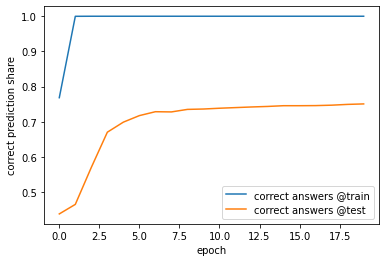

In [ ]:
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 20, input_length=xLen))
modelE.add(Dropout(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation='relu'))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='sigmoid'))

modelE.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = modelE.fit(
    xTrain, yTrain,
    epochs = 20,
    batch_size = 128,
    validation_data = (xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

In [ ]:
xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(modelE, xTestLabels, 'Dense')

model: Dense
Label: О. Генри   86% the model recognized as О. Генри correct prediction
Label: Стругацкие 84% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   58% the model recognized as Булгаков correct prediction
Label: Саймак     67% the model recognized as Саймак   correct prediction
Label: Фрай       83% the model recognized as Фрай     correct prediction
Label: Брэдберри  71% the model recognized as Брэдберриcorrect prediction

average prediction rate: 75 %


Точность такой модели упала существенно.

В целом, процесс обработки текста можно представить следующим образом:

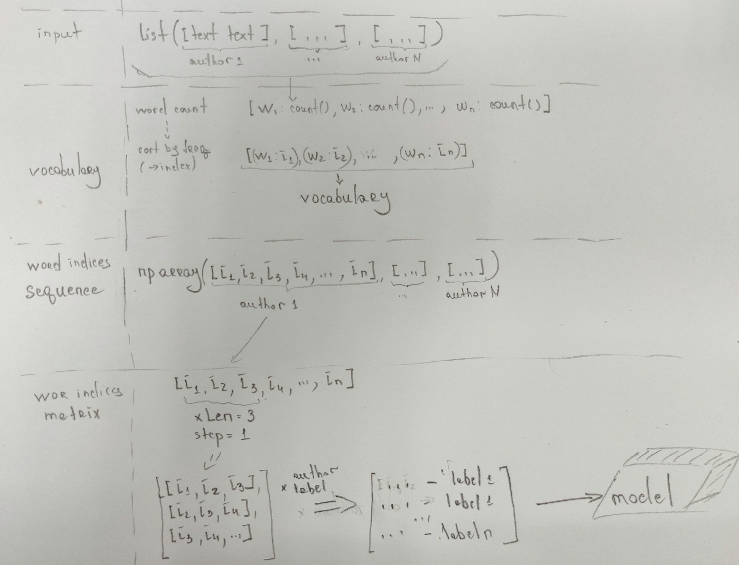